<a href="https://colab.research.google.com/github/umiSirya/MachineLearning_2/blob/main/Air_Quality_Forecasting(Time_Series).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [89]:
!pip install liac-arff
!pip install prophet

In [109]:
import numpy as np
import pandas as pd
import arff

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet
from sklearn.metrics import mean_absolute_error




In [91]:
# Load the ARFF file
with open('air_dataset.arff', 'r') as f:
    data = arff.load(f)

# Convert to DataFrame
df = pd.DataFrame(data['data'], columns=[attr[0] for attr in data['attributes']])
print(df.head())


   No  year  month  day  hour  PM2.5  PM10   SO2   NO2     CO    O3  TEMP  \
0   1  2013      3    1     0    4.0   4.0   4.0   7.0  300.0  77.0  -0.7   
1   2  2013      3    1     1    8.0   8.0   4.0   7.0  300.0  77.0  -1.1   
2   3  2013      3    1     2    7.0   7.0   5.0  10.0  300.0  73.0  -1.1   
3   4  2013      3    1     3    6.0   6.0  11.0  11.0  300.0  72.0  -1.4   
4   5  2013      3    1     4    3.0   3.0  12.0  12.0  300.0  72.0  -2.0   

     PRES  DEWP  RAIN   wd  WSPM       station  
0  1023.0 -18.8   0.0  NNW   4.4  Aotizhongxin  
1  1023.2 -18.2   0.0    N   4.7  Aotizhongxin  
2  1023.5 -18.2   0.0  NNW   5.6  Aotizhongxin  
3  1024.5 -19.4   0.0   NW   3.1  Aotizhongxin  
4  1025.2 -19.5   0.0    N   2.0  Aotizhongxin  


**Explaratory Data Analysis**

In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420768 entries, 0 to 420767
Data columns (total 18 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   No       420768 non-null  int64  
 1   year     420768 non-null  int64  
 2   month    420768 non-null  int64  
 3   day      420768 non-null  int64  
 4   hour     420768 non-null  int64  
 5   PM2.5    412029 non-null  float64
 6   PM10     414319 non-null  float64
 7   SO2      411747 non-null  float64
 8   NO2      408652 non-null  float64
 9   CO       400067 non-null  float64
 10  O3       407491 non-null  float64
 11  TEMP     420370 non-null  float64
 12  PRES     420375 non-null  float64
 13  DEWP     420365 non-null  float64
 14  RAIN     420378 non-null  float64
 15  wd       418946 non-null  object 
 16  WSPM     420450 non-null  float64
 17  station  420768 non-null  object 
dtypes: float64(11), int64(5), object(2)
memory usage: 57.8+ MB


In [93]:
# drop the No column
df.drop('No', axis=1, inplace=True)

In [94]:
#null values
df.isnull().sum()


,0
year,0
month,0
day,0
hour,0
PM2.5,8739
PM10,6449
SO2,9021
NO2,12116
CO,20701
O3,13277


<Axes: >

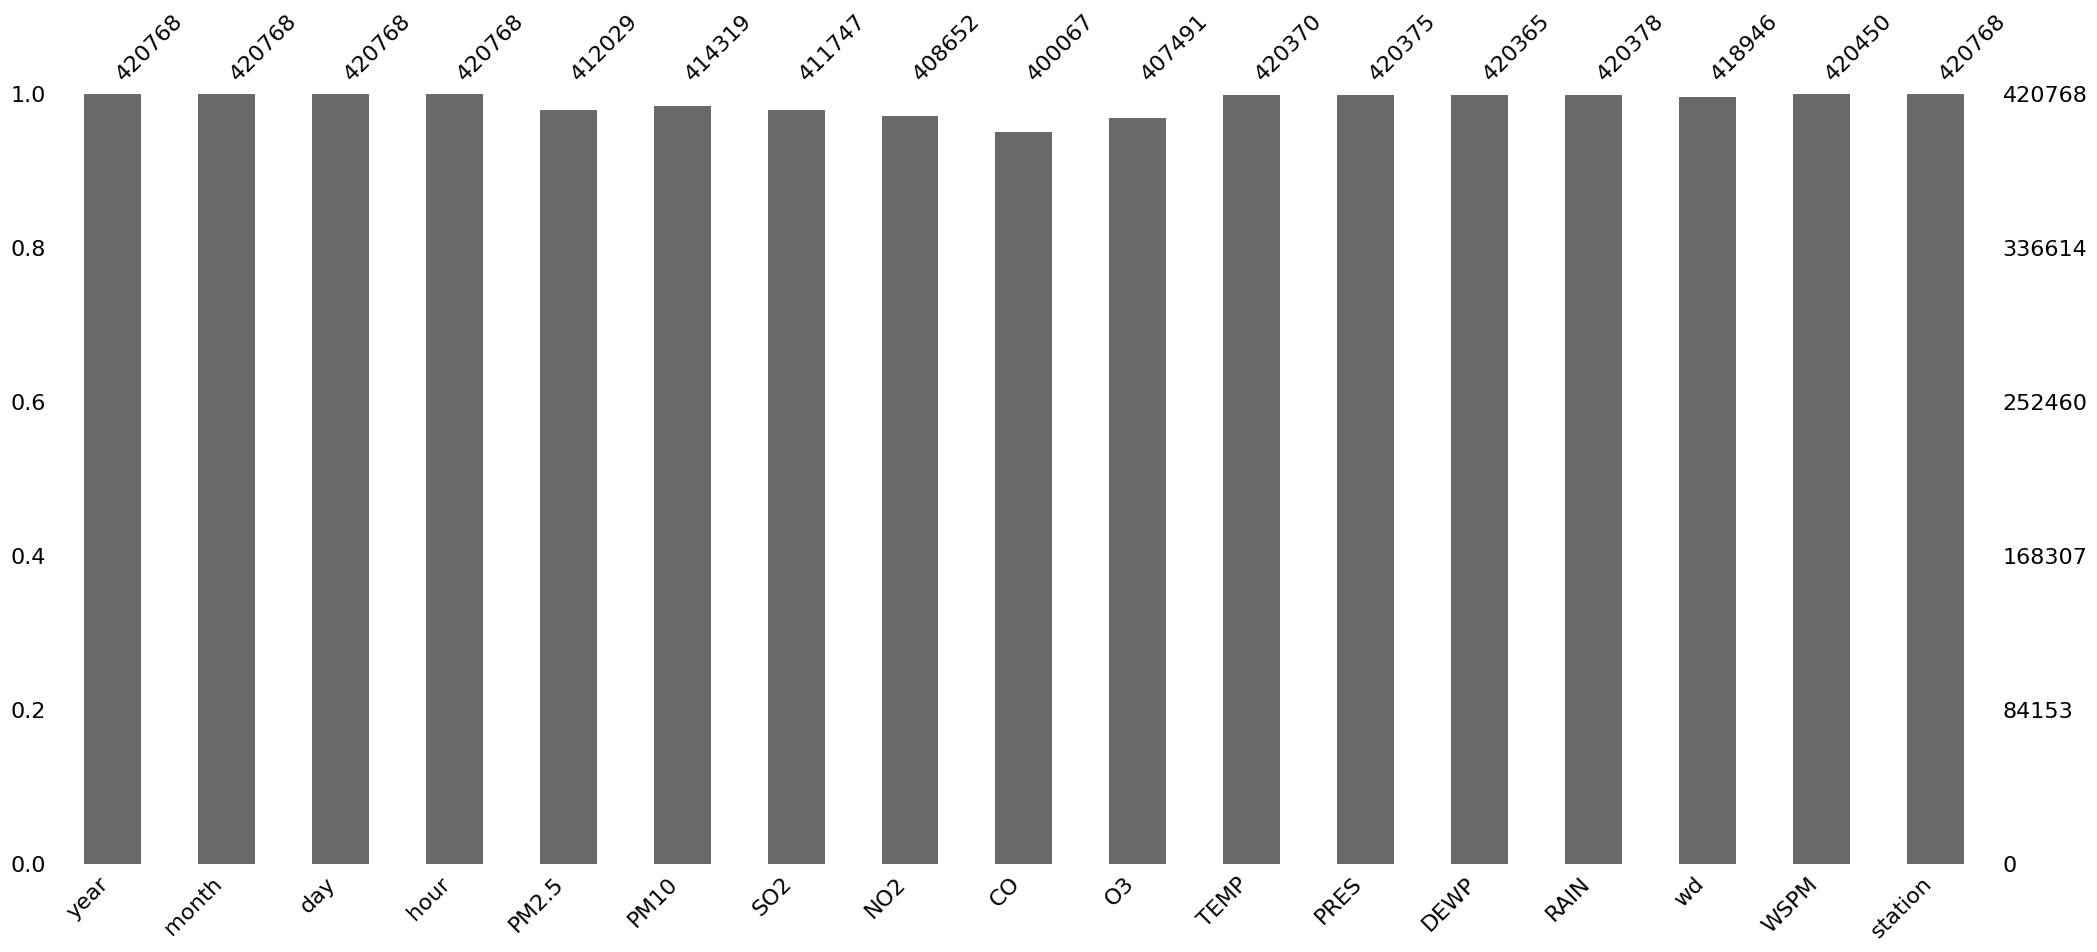

In [95]:
msno.bar(df)

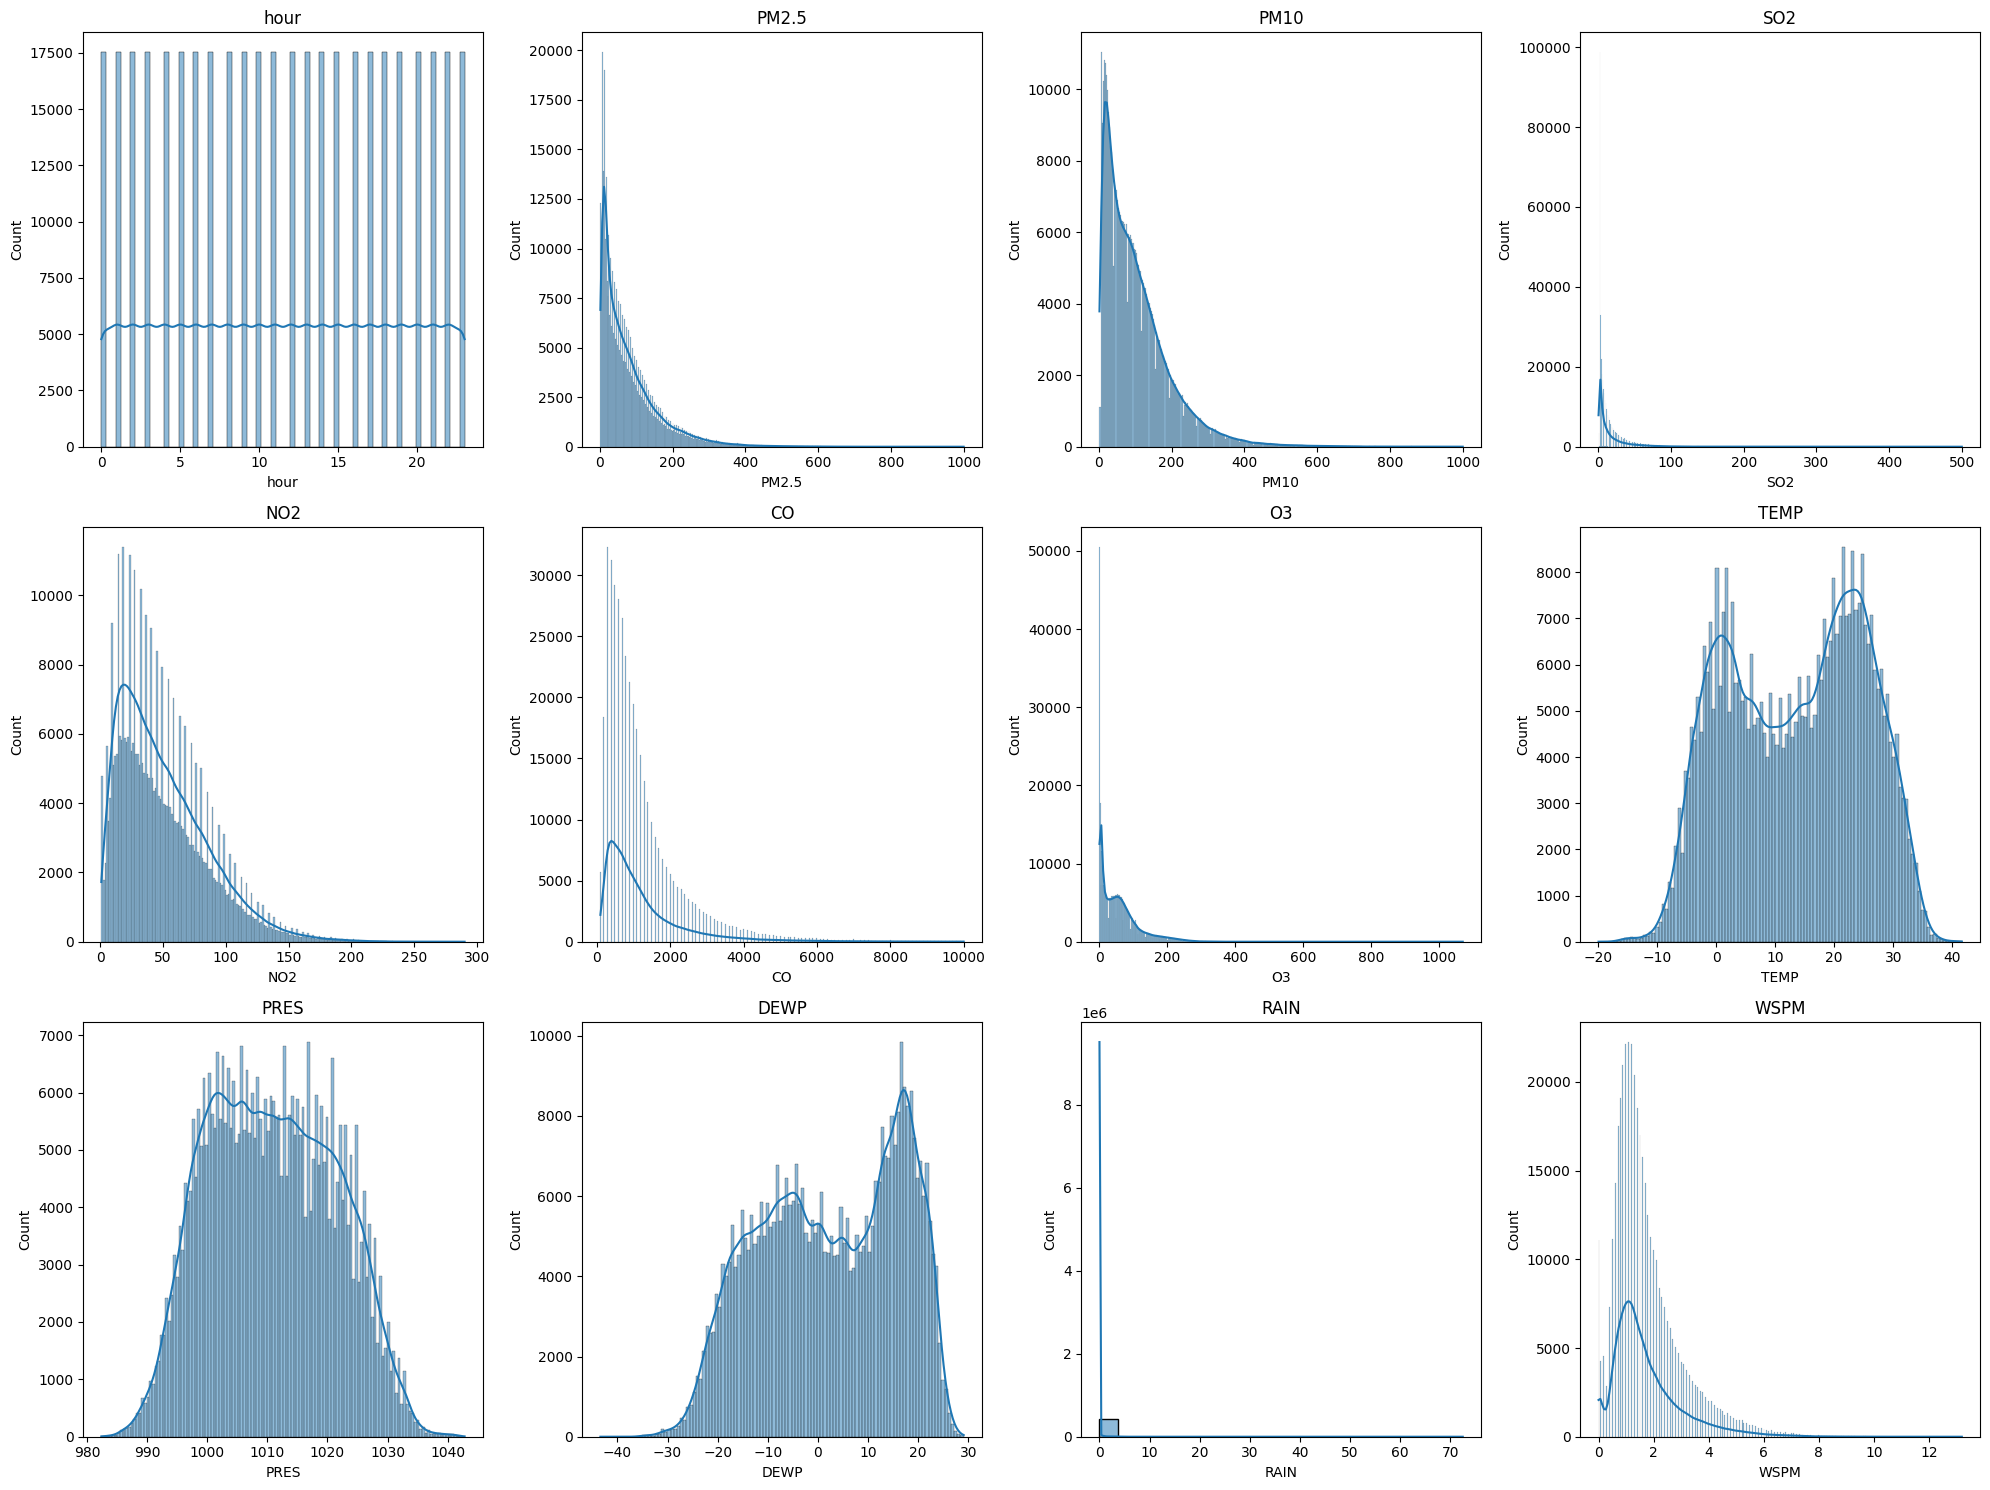

In [96]:

# Distribution graph of numerical columns
num_cols = 4
num_rows = (len(['hour', 'PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']) + num_cols - 1) // num_cols

# List of columns to be plotted
cols_to_plot = ['hour', 'PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']

# Set up the subplot grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))
axes = axes.flatten()

for idx, column in enumerate(cols_to_plot):
    sns.histplot(df[column], kde=True, ax=axes[idx])
    axes[idx].set_title(column)

for ax in axes[len(cols_to_plot):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()



**Data Cleaning**

In [97]:
# Filling null values in temp, pres, dewp, rain, wspm using interpolation
columns_to_interpolate = ['TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']
df[columns_to_interpolate] = df[columns_to_interpolate].interpolate(method='linear')

# filling null values with median for PM2.5, PM10, S02,NO2,CO columns
pollutants = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3']
for pollutant in pollutants:
    df[pollutant].fillna(df[pollutant].median(), inplace=True)

# filling wd with mode(categorical data)
df['wd'].fillna(df['wd'].mode()[0], inplace=True)



<ipython-input-97-173e74281cfd>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[pollutant].fillna(df[pollutant].median(), inplace=True)
<ipython-input-97-173e74281cfd>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)

**Feature Engineering**

In [98]:
# Combine year, month, day into a date column
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


# Remove duplicate dates
df = df.drop_duplicates(subset=['date'], keep='first')

# Make 'date' column into the index column
df.set_index('date', inplace=True)

# Sort the date column in ascending order
df = df.sort_index()

# Set the frequency to daily
df = df.asfreq('D')  # This sets the frequency to daily

# Fill missing values if needed
df.fillna(method='ffill', inplace=True)

print(df.head())


            year  month  day  hour  PM2.5   PM10   SO2    NO2      CO    O3  \
date                                                                          
2013-03-01  2013      3    1     0    4.0    4.0   4.0    7.0   300.0  77.0   
2013-03-02  2013      3    2     0   22.0   24.0  24.0   44.0   500.0  44.0   
2013-03-03  2013      3    3     0  112.0  130.0  73.0  100.0  1899.0   2.0   
2013-03-04  2013      3    4     0   42.0   83.0  51.0   86.0  1300.0   4.0   
2013-03-05  2013      3    5     0   71.0  108.0  66.0   78.0  1100.0  84.0   

            TEMP    PRES  DEWP  RAIN   wd  WSPM       station  
date                                                           
2013-03-01  -0.7  1023.0 -18.8   0.0  NNW   4.4  Aotizhongxin  
2013-03-02  -0.4  1031.0 -17.6   0.0  ENE   1.4  Aotizhongxin  
2013-03-03  -1.4  1020.4 -13.0   0.0  NNE   1.2  Aotizhongxin  
2013-03-04   7.7  1015.7 -11.1   0.0    N   2.6  Aotizhongxin  
2013-03-05   4.7  1015.2  -9.1   0.0   SW   1.6  Aotizhongxin 

<ipython-input-98-0cf888c53c65>:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [99]:
# Lag Feature
df['PM2.5_lag1'] = df['PM2.5'].shift(1)
df['PM2.5_lag24'] = df['PM2.5'].shift(24)
df['PM2.5_lag48'] = df['PM2.5'].shift(48)
df['PM2.5_lag72'] = df['PM2.5'].shift(72)

# temperature difference (temp-DEWP)
df['temp_dewp_diff'] = df['TEMP'] - df['DEWP']



In [100]:
df.tail()

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,...,DEWP,RAIN,wd,WSPM,station,PM2.5_lag1,PM2.5_lag24,PM2.5_lag48,PM2.5_lag72,temp_dewp_diff
date,,,,,,,,,,,,,,,,,,,,,
2017-02-24,2017,2,24,0,46.0,53.0,11.0,85.0,900.0,27.0,...,-9.9,0.0,WSW,0.8,Aotizhongxin,13.0,70.0,241.0,19.0,10.6
2017-02-25,2017,2,25,0,12.0,19.0,13.0,65.0,500.0,33.0,...,-11.7,0.0,W,1.6,Aotizhongxin,46.0,5.0,66.0,73.0,17.6
2017-02-26,2017,2,26,0,24.0,33.0,8.0,57.0,600.0,51.0,...,-8.6,0.0,NNE,1.0,Aotizhongxin,12.0,154.0,10.0,22.0,12.8
2017-02-27,2017,2,27,0,38.0,71.0,12.0,115.0,100.0,2.0,...,-7.8,0.0,WSW,0.9,Aotizhongxin,24.0,148.0,51.0,135.0,13.2
2017-02-28,2017,2,28,0,56.0,56.0,22.0,119.0,1400.0,18.0,...,-8.3,0.0,NNE,1.5,Aotizhongxin,38.0,321.0,91.0,347.0,18.2


In [101]:
# # make date column into the index column
# df.set_index('date', inplace=True)

# # sort the date column in ascending order
# df = df.sort_index()

# # Set the frequency to daily
# df = df.asfreq('D')  # This sets the frequency to daily

# # Fill missing values if needed
# df.fillna(method='ffill', inplace=True)


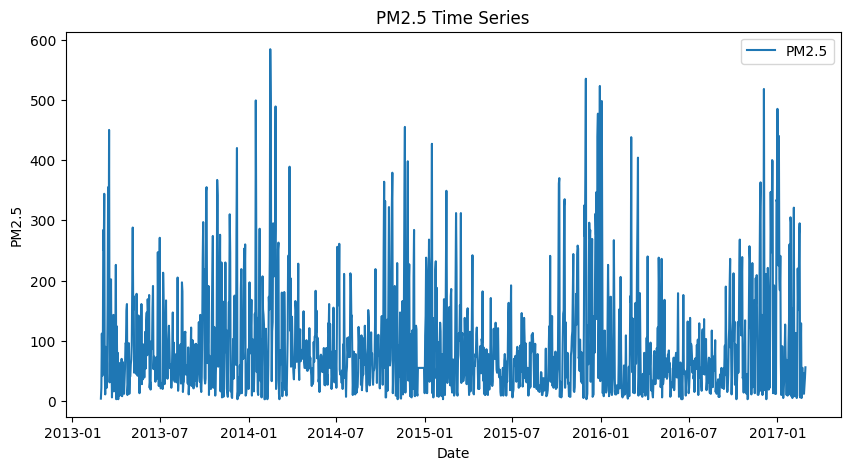

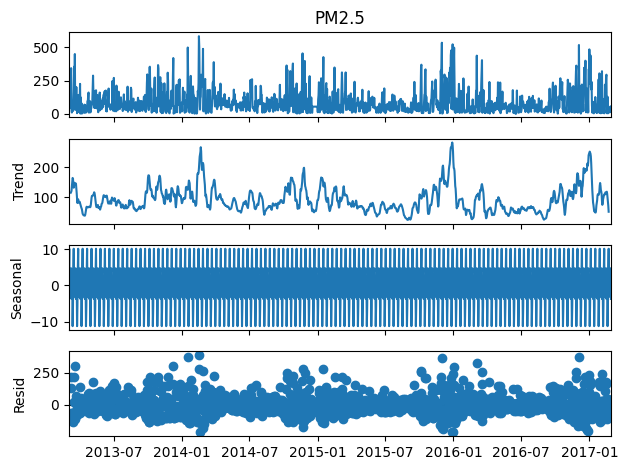

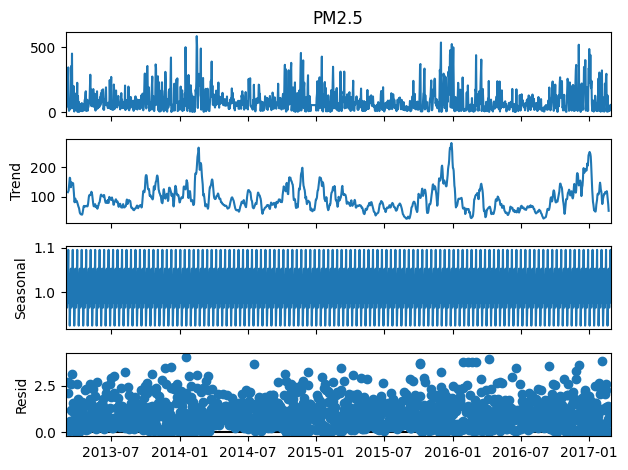

In [102]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Visualize the time series
plt.figure(figsize=(10, 5))
plt.plot(df['PM2.5'], label='PM2.5')
plt.xlabel('Date')
plt.ylabel('PM2.5')
plt.title('PM2.5 Time Series')
plt.legend()
plt.show()

# Decompose the time series
decomposition = seasonal_decompose(df['PM2.5'], model='additive', period=12)
fig = decomposition.plot()
plt.show()

# Decompose the time series
decomposition = seasonal_decompose(df['PM2.5'], model='multiplicative', period=12)
fig = decomposition.plot()
plt.show()


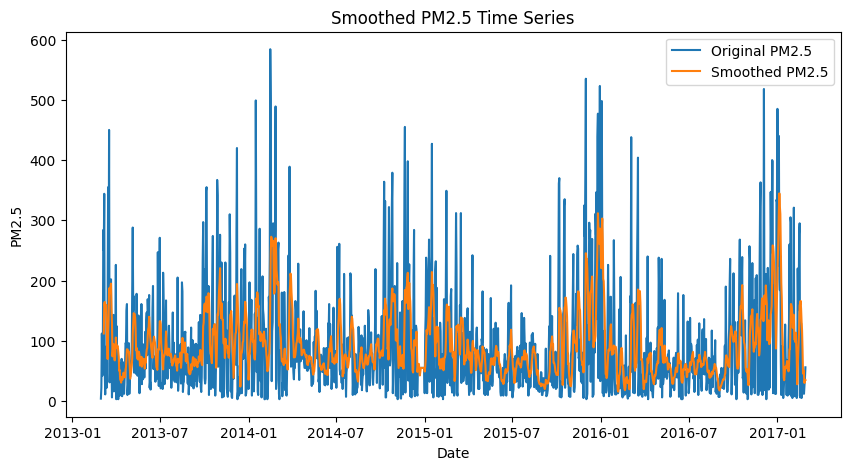

In [103]:
# applied smoothing technique moving average
df['PM2.5_smooth'] = df['PM2.5'].rolling(window=7).mean()

plt.figure(figsize=(10, 5))
plt.plot(df['PM2.5'], label='Original PM2.5')
plt.plot(df['PM2.5_smooth'], label='Smoothed PM2.5')
plt.xlabel('Date')
plt.ylabel('PM2.5')
plt.title('Smoothed PM2.5 Time Series')
plt.legend()
plt.show()


Train Test Split

In [104]:
## train test split
train = int(len(df) * 0.8)
train, test = df[:train], df[train:]


In [105]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Additional regressors for training
X_train = train[['TEMP', 'PRES', 'DEWP', 'WSPM']]
X_test = test[['TEMP', 'PRES', 'DEWP', 'WSPM']]

# Fit ARIMA model with exogenous variables
arima_model = ARIMA(train['PM2.5'], order=(1, 1, 1), exog=X_train)
arima_result = arima_model.fit()
print(arima_result.summary())

# Fit SARIMAX model with exogenous variables
sarima_model = SARIMAX(train['PM2.5'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), exog=X_train)
sarima_result = sarima_model.fit()
print(sarima_result.summary())


                               SARIMAX Results                                
Dep. Variable:                  PM2.5   No. Observations:                 1168
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -6600.251
Date:                Wed, 15 Jan 2025   AIC                          13214.502
Time:                        18:13:51   BIC                          13249.938
Sample:                    03-01-2013   HQIC                         13227.869
                         - 05-11-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
TEMP          -0.2578      0.915     -0.282      0.778      -2.052       1.536
PRES          -2.4848      0.465     -5.344      0.000      -3.396      -1.573
DEWP           7.3601      0.528     13.943      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                              PM2.5   No. Observations:                 1168
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -6552.909
Date:                            Wed, 15 Jan 2025   AIC                          13123.817
Time:                                    18:14:14   BIC                          13169.284
Sample:                                03-01-2013   HQIC                         13140.976
                                     - 05-11-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
TEMP          -0.5035      0.930     -0.541      0.588      -2.327       1.319
PRES          -2.6042      0.498   

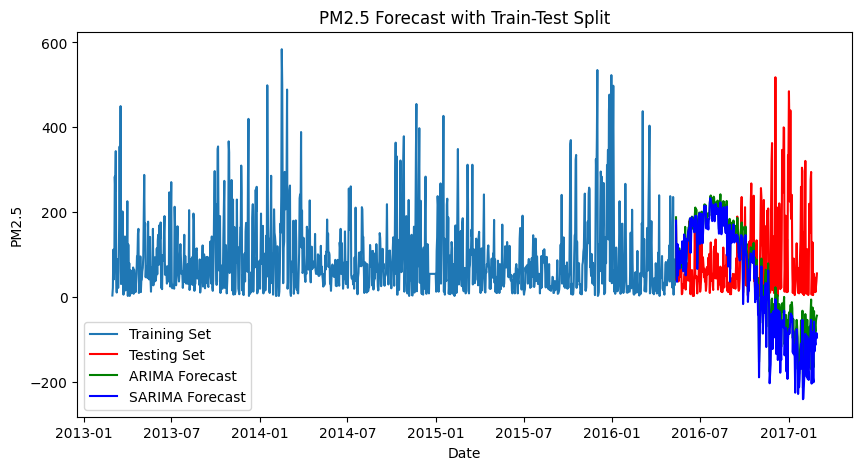

In [106]:
# Forecast using ARIMA
forecast_arima = arima_result.get_forecast(steps=len(test), exog=X_test)
forecast_arima_mean = forecast_arima.predicted_mean

# Forecast using SARIMA
forecast_sarima = sarima_result.get_forecast(steps=len(test), exog=X_test)
forecast_sarima_mean = forecast_sarima.predicted_mean

# Visualize the forecast
plt.figure(figsize=(10, 5))
plt.plot(train['PM2.5'], label='Training Set')
plt.plot(test['PM2.5'], label='Testing Set', color='red')
plt.plot(forecast_arima_mean.index, forecast_arima_mean, label='ARIMA Forecast', color='green')
plt.plot(forecast_sarima_mean.index, forecast_sarima_mean, label='SARIMA Forecast', color='blue')
plt.xlabel('Date')
plt.ylabel('PM2.5')
plt.title('PM2.5 Forecast with Train-Test Split')
plt.legend()
plt.show()


In [111]:
df.head()

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,...,RAIN,wd,WSPM,station,PM2.5_lag1,PM2.5_lag24,PM2.5_lag48,PM2.5_lag72,temp_dewp_diff,PM2.5_smooth
date,,,,,,,,,,,,,,,,,,,,,
2013-03-01,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,...,0.0,NNW,4.4,Aotizhongxin,NaN,NaN,NaN,NaN,18.1,NaN
2013-03-02,2013,3,2,0,22.0,24.0,24.0,44.0,500.0,44.0,...,0.0,ENE,1.4,Aotizhongxin,4.0,NaN,NaN,NaN,17.2,NaN
2013-03-03,2013,3,3,0,112.0,130.0,73.0,100.0,1899.0,2.0,...,0.0,NNE,1.2,Aotizhongxin,22.0,NaN,NaN,NaN,11.6,NaN
2013-03-04,2013,3,4,0,42.0,83.0,51.0,86.0,1300.0,4.0,...,0.0,N,2.6,Aotizhongxin,112.0,NaN,NaN,NaN,18.8,NaN
2013-03-05,2013,3,5,0,71.0,108.0,66.0,78.0,1100.0,84.0,...,0.0,SW,1.6,Aotizhongxin,42.0,NaN,NaN,NaN,13.8,NaN


In [113]:
# Combine year, month, day into a date column
df['date1'] = pd.to_datetime(df[['year', 'month', 'day']])

# Prepare the DataFrame for Prophet
df_prophet = df[['date1', 'PM2.5']].rename(columns={'date1': 'ds', 'PM2.5': 'y'})

In [116]:
# Define the split index (80-20 split)
split_index = int(len(df_prophet) * 0.8)

# Create train and test sets
train_df = df_prophet.iloc[:split_index]
test_df = df_prophet.iloc[split_index:]


In [117]:
# Initialize the Prophet model
model = Prophet()

# Fit the model
model.fit(train_df)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdn_dloaw/z9jx1lwv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdn_dloaw/6i29h2j1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55770', 'data', 'file=/tmp/tmpdn_dloaw/z9jx1lwv.json', 'init=/tmp/tmpdn_dloaw/6i29h2j1.json', 'output', 'file=/tmp/tmpdn_dloaw/prophet_model6lxrbu5t/prophet_model-20250115183015.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:30:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:30:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [118]:
# Make future DataFrame for the test period
future_test = model.make_future_dataframe(periods=len(test_df))

# Predict future values
forecast = model.predict(future_test)

# Extract the forecast for the test period
forecast_test = forecast.iloc[-len(test_df):]

# Display forecast
print(forecast_test[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())


             ds        yhat  yhat_lower  yhat_upper
1456 2017-02-24  106.724791   -3.452551  221.609298
1457 2017-02-25  110.987389    4.536945  210.039534
1458 2017-02-26  108.406083   -1.153336  220.341422
1459 2017-02-27   97.919289  -11.424148  199.984137
1460 2017-02-28   94.456040  -11.166941  203.984760


<ipython-input-123-7fd68782dec6>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_test['yhat_smooth'] = moving_average(forecast_test['yhat'], window=5)


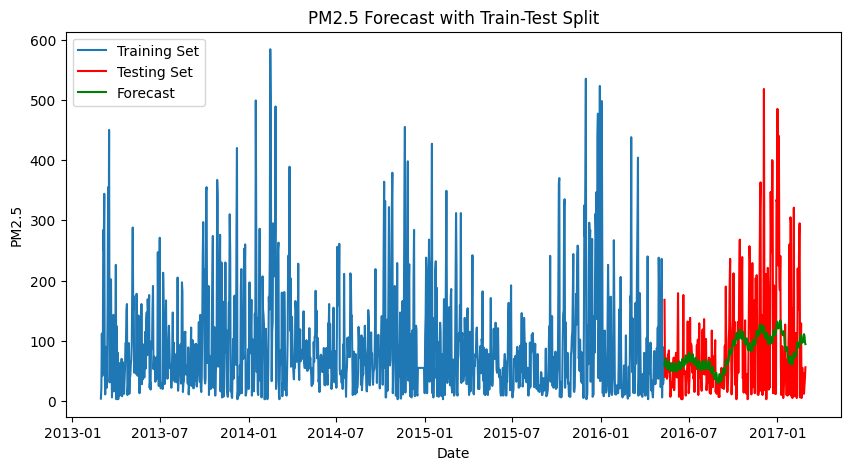

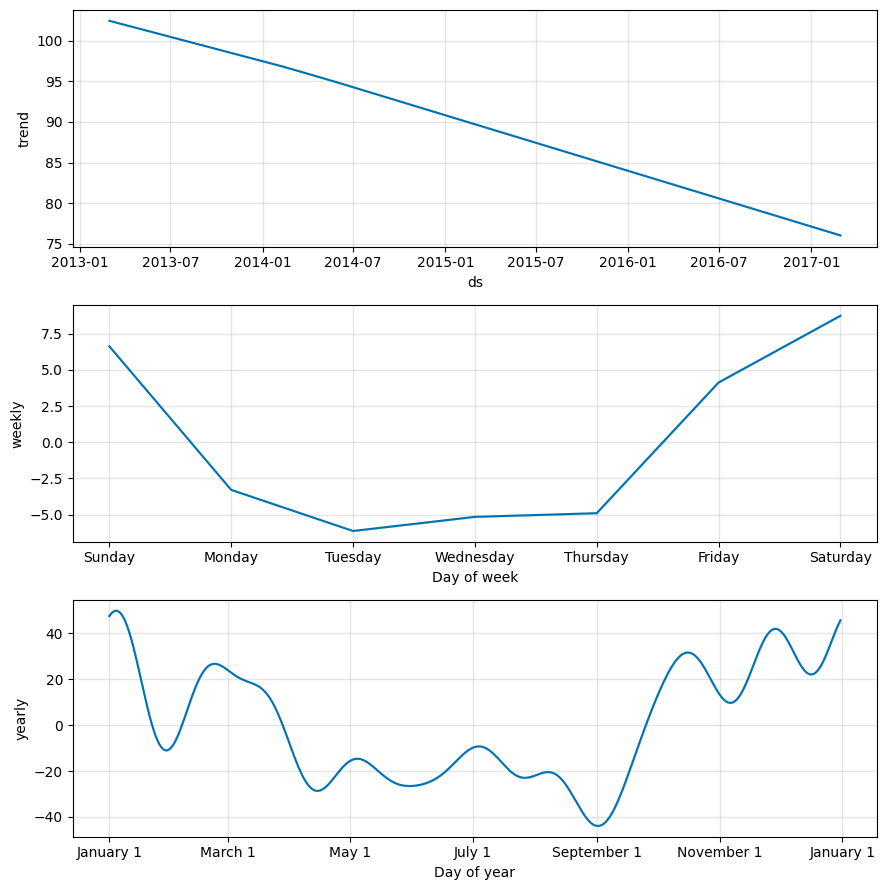

Mean Absolute Error: 59.82674196243683


In [123]:
# Function to calculate moving average
def moving_average(series, window):
  return series.rolling(window=window).mean()

# Apply moving average smoothing to the forecast
forecast_test['yhat_smooth'] = moving_average(forecast_test['yhat'], window=5)

# Plot the forecast
plt.figure(figsize=(10, 5))
plt.plot(train_df['ds'], train_df['y'], label='Training Set')
plt.plot(test_df['ds'], test_df['y'], label='Testing Set', color='red')
plt.plot(forecast_test['ds'], forecast_test['yhat'], label='Forecast', color='green')
plt.xlabel('Date')
plt.ylabel('PM2.5')
plt.title('PM2.5 Forecast with Train-Test Split')
plt.legend()
plt.show()

# Plot the forecast components (trend, weekly seasonality, yearly seasonality)
fig2 = model.plot_components(forecast)
plt.show()

# Calculate Mean Absolute Error
mae = mean_absolute_error(test_df['y'], forecast_test['yhat'])
print(f'Mean Absolute Error: {mae}')
